## LSTM RNN from scratch

© Christian Herta, Davide Posillipo

Adapted from http://christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/LSTM.php, for the Sequences class at Data Science Retreat, 2020, Berlin.

Reference reading for the mathematical explanation of LSTM: Deep Learning (Goodfellow et al.), section 10.10. 

In [1]:
import numpy as np
import theano
import theano.tensor as T

dtype=theano.config.floatX

from reberGrammar import reberGrammar

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def sample_weights(sizeX, sizeY):
    values = np.ndarray([sizeX, sizeY], dtype=dtype)
    for dx in range(sizeX):
        vals = np.random.uniform(low=-1., high=1.,  size=(sizeY,))
        #vals_norm = np.sqrt((vals**2).sum())
        #vals = vals / vals_norm
        values[dx,:] = vals
    _,svs,_ = np.linalg.svd(values)
    #svs[0] is the largest singular value                      
    values = values / svs[0]
    return values  

In [3]:
n_in = 7 # for embedded reber grammar
n_hidden = n_i = n_c = n_o = n_f = 10
n_y = 7 # for embedded reber grammar

# initialize weights
# i_t and o_t should be "open" or "closed"
# f_t should be "open" (don't forget at the beginning of training)
# we try to archive this by appropriate initialization of the corresponding biases 

W_xi = theano.shared(sample_weights(n_in, n_i))  
W_hi = theano.shared(sample_weights(n_hidden, n_i))  
W_ci = theano.shared(sample_weights(n_c, n_i))  
b_i = theano.shared(np.cast[dtype](np.random.uniform(-0.5,.5,size = n_i)))
W_xf = theano.shared(sample_weights(n_in, n_f)) 
W_hf = theano.shared(sample_weights(n_hidden, n_f))
W_cf = theano.shared(sample_weights(n_c, n_f))
b_f = theano.shared(np.cast[dtype](np.random.uniform(0, 1.,size = n_f)))
W_xc = theano.shared(sample_weights(n_in, n_c))  
W_hc = theano.shared(sample_weights(n_hidden, n_c))
b_c = theano.shared(np.zeros(n_c, dtype=dtype))
W_xo = theano.shared(sample_weights(n_in, n_o))
W_ho = theano.shared(sample_weights(n_hidden, n_o))
W_co = theano.shared(sample_weights(n_c, n_o))
b_o = theano.shared(np.cast[dtype](np.random.uniform(-0.5,.5,size = n_o)))
W_hy = theano.shared(sample_weights(n_hidden, n_y))
b_y = theano.shared(np.zeros(n_y, dtype=dtype))

c0 = theano.shared(np.zeros(n_hidden, dtype=dtype))
h0 = T.tanh(c0)

params = [W_xi, W_hi, W_ci, b_i, W_xf, W_hf, 
          W_cf, b_f, W_xc, W_hc, b_c, W_xo, 
          W_ho, W_co, b_o, W_hy, b_y, c0]

In [4]:
sigma = lambda x: 1 / (1 + T.exp(-x))

act = T.tanh

# sequences: x_t
# prior results: h_tm1, c_tm1
# non-sequences: W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, b_f, W_xc, W_hc, 
#                      b_c, W_xo, W_ho, W_co, b_o, W_hy, b_y
def one_lstm_step(x_t, h_tm1, c_tm1, W_xi, W_hi, 
                  W_ci, b_i, W_xf, W_hf, 
                  W_cf, b_f, W_xc, W_hc, 
                  b_c, W_xo, W_ho, W_co, 
                  b_o, W_hy, b_y):
    i_t = sigma(theano.dot(x_t, W_xi) + theano.dot(h_tm1, W_hi) + theano.dot(c_tm1, W_ci) + b_i)
    f_t = sigma(theano.dot(x_t, W_xf) + theano.dot(h_tm1, W_hf) + theano.dot(c_tm1, W_cf) + b_f)
    c_t = f_t * c_tm1 + i_t * act(theano.dot(x_t, W_xc) + theano.dot(h_tm1, W_hc) + b_c) 
    o_t = sigma(theano.dot(x_t, W_xo)+ theano.dot(h_tm1, W_ho) + theano.dot(c_t, W_co)  + b_o)
    h_t = o_t * act(c_t)
    y_t = sigma(theano.dot(h_t, W_hy) + b_y) 
    return [h_t, c_t, y_t]

In [5]:
#input 
v = T.matrix(dtype=dtype)

# target
target = T.matrix(dtype=dtype)

In [6]:
# hidden and outputs of the entire sequence
[h_vals, _, y_vals], _ = theano.scan(fn=one_lstm_step, 
                                  sequences = dict(input=v, taps=[0]), 
                                  outputs_info = [h0, c0, None ], # corresponds to return type of fn
                                  non_sequences = [W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, b_f, 
                                                   W_xc, W_hc, b_c, W_xo, W_ho, W_co, b_o, W_hy, b_y] )

In [7]:
# Loss function
cost = -T.mean(target * T.log(y_vals)+ (1.- target) * T.log(1. - y_vals))

In [8]:
# learning rate
lr = np.cast[dtype](.1)
learning_rate = theano.shared(lr)

In [9]:
gparams = []
for param in params:
    gparam = T.grad(cost, param)  
    gparams.append(gparam)

updates=[]
for param, gparam in zip(params, gparams):
    updates.append((param, param - gparam * learning_rate))

In [10]:
reber_grammar = reberGrammar()
train_data = reber_grammar.get_n_embedded_examples(1000)

In [11]:
learn_rnn_fn = theano.function(inputs = [v, target],
                               outputs = cost,
                               updates = updates)


In [12]:
nb_epochs=250
train_errors = np.ndarray(nb_epochs)
def train_rnn(train_data):      
  for x in range(nb_epochs):
    error = 0.
    for j in range(len(train_data)):  
        index = np.random.randint(0, len(train_data))
        i, o = train_data[index]
        train_cost = learn_rnn_fn(i, o)
        error += train_cost
    train_errors[x] = error 
    
train_rnn(train_data)

(0.0, 50)

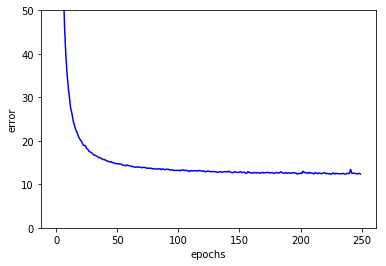

In [13]:
plt.plot(np.arange(nb_epochs), train_errors, 'b-')
plt.xlabel('epochs')
plt.ylabel('error')
plt.ylim(0., 50)

### Predictions

In [14]:
predictions = theano.function(inputs = [v], outputs = y_vals)

In [15]:
test_data = reber_grammar.get_n_embedded_examples(5)

In [16]:
def print_out(test_data):
    for i,o in test_data:
        p = predictions(i)
        print(o[1]) # target
        print(p[-2]) # prediction
        print('\n') 

In [17]:
print_out(test_data)

[1. 0. 0. 0. 0. 0. 0.]
[5.15503480e-07 4.67473202e-01 6.19967309e-04 7.18173684e-04
 5.41825340e-01 1.58530711e-04 5.69032380e-04]


[1. 0. 0. 0. 0. 0. 0.]
[5.78301949e-07 4.33860010e-01 3.91548798e-04 4.52094208e-04
 5.52285645e-01 2.24119967e-04 8.28366899e-04]


[1. 0. 0. 0. 0. 0. 0.]
[2.33079404e-07 5.47955875e-01 2.98458146e-04 3.32689560e-04
 4.53537456e-01 2.69118610e-04 1.28030685e-03]


[1. 0. 0. 0. 0. 0. 0.]
[3.31972911e-07 5.85525540e-01 2.58743556e-04 2.89143653e-04
 4.09384888e-01 3.57306515e-04 1.29443938e-03]


[1. 0. 0. 0. 0. 0. 0.]
[4.43354290e-07 4.61695144e-01 1.48503138e-04 1.67186433e-04
 5.22763686e-01 4.23327404e-04 1.88332013e-03]


